# OT-guided regression

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ot
from scipy.ndimage import affine_transform
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression

from utils import pixel_dist_3d

## Create synthetic data

### Source frame

frame shape: (50, 25, 5)
num. pixels: 6250


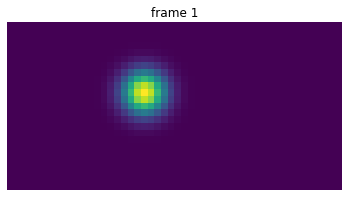

In [3]:
img_shape = (50, 25, 5)
n_pixels = img_shape[0] * img_shape[1] * img_shape[2]

# Grid for evaluating densities on
xg, yg, zg = np.mgrid[0:img_shape[0], 0:img_shape[1], 0:img_shape[2]]
grid = np.stack((xg, yg, zg), axis=-1)

# Source frame is Gaussian PDF
mu = np.array([20, 10, 3])
cov = 5 * np.eye(3)
frame_1 = multivariate_normal.pdf(grid, mu, cov).reshape(img_shape)

print(f'frame shape: {img_shape}')
print(f'num. pixels: {n_pixels}')

plt.imshow(np.max(frame_1, 2).T);
plt.title('frame 1')
plt.axis('off');

### Target frame

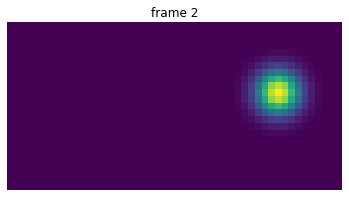

In [4]:
# Affine transformation to apply to source image
beta = np.eye(3, 3)
alpha = np.array([20, 0, 0])

# Inverse of transformation (for transforming frame)
inv_beta = np.linalg.inv(beta)
inv_alpha = -inv_beta @ alpha

# Transform source frame into target frame
frame_2 = affine_transform(frame_1, inv_beta, inv_alpha)

plt.imshow(np.max(frame_2, 2).T);
plt.title('frame 2')
plt.axis('off');

## Compare OT-based regression methods for recovering tranformation between frames

### Compute optimal transport plan between frames

In [5]:
# Normalized pixel distance matrix 
M_nn = pixel_dist_3d(*img_shape)
M = M_nn / np.median(M_nn)

# Entropic regularization parameter
reg = 1e-3

# Compute transport plan
P = ot.sinkhorn(frame_1.flatten(), frame_2.flatten(), M, reg, verbose=False)

### Compute values used for all regression methods

In [6]:
# Compute pushforward
Q = P / frame_1.reshape(-1, 1)

# Matrix containing pixel coordinates
X = grid.reshape(-1, 3)

# Multiply grid points by pushforward matrix to get 'transformed' points
Y = Q @ X

In [7]:
def print_regression_report(alpha_est, beta_est, verbose=False):
    
    alpha_mse = np.sum((alpha_est - alpha) ** 2) / 3
    beta_mse = np.sum((beta_est - beta) ** 2) / 9

    print(f'MSE (alpha): {alpha_mse:7.4f}')
    print(f'MSE (beta):  {beta_mse:7.4f}')

    if verbose:
        
        print('alpha (est):')
        print(alpha_est)

        print('beta (est):')
        print(beta_est)

### Method 1: Ordinary Least Squares (OLS) regression with no weights

In [8]:
ols = LinearRegression(fit_intercept=True)
ols.fit(X, Y)

print_regression_report(ols.intercept_, ols.coef_)

MSE (alpha): 12.0839
MSE (beta):   0.0276


### Method 2: Weights are pixel values from first frame

In [9]:
wls_1 = LinearRegression(fit_intercept=True)
wls_1.fit(X, Y, sample_weight=frame_1.flatten())

print_regression_report(wls_1.intercept_, wls_1.coef_)

MSE (alpha):  0.2058
MSE (beta):   0.0003


### Method 3: Weights are inverse variance values

In [10]:
# Compute isotropic variances for each pixel
sq_dist = ot.dist(X, Y, metric='sqeuclidean')
var = np.sum(sq_dist * Q / 3, axis=1)

# Set weights to reciprocal of variance
weights = 1 / var

wls_2 = LinearRegression(fit_intercept=True)
wls_2.fit(X, Y, sample_weight=weights)

print_regression_report(wls_2.intercept_, wls_2.coef_)

MSE (alpha): 74.8537
MSE (beta):   0.0578
